Dataset shape: (506, 14)


<ipython-input-1-d4d37ff7c751>:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


RMSE: 2.64
R2 Score: 0.9050


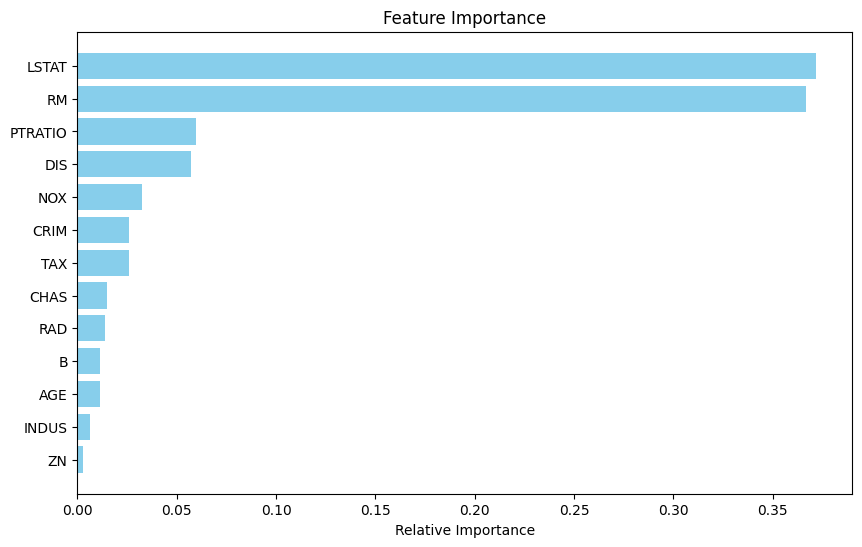

Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best RMSE: 3.7748136869863984


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

# Load dataset
# Original URL causing 404 error: url = "https://raw.githubusercontent.com/selva86/datasets/master/AmesHousing.txt"
# Updated URL from UCI Machine Learning Repository:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
df = pd.read_csv(url, delimiter="\s+", header=None) # Updated to use space as delimiter and no header
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'] # Adding column names

print("Dataset shape:", df.shape)
df.head()
# Remove columns with too many missing values
missing_threshold = 0.3
df = df[df.columns[df.isnull().mean() < missing_threshold]]

# Fill remaining nulls with median or mode
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

# Encode categorical features
df = pd.get_dummies(df, drop_first=True)

# Split into features and target
X = df.drop('MEDV', axis=1) # Changed target variable to 'MEDV'
y= df['MEDV']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Train XGBoost Regressor
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
xgb.fit(X_train_scaled, y_train)

# Predict
y_pred = xgb.predict(X_test_scaled)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")
importances = xgb.feature_importances_
features = X.columns
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.barh(range(len(indices)), importances[indices], color="skyblue", align="center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid = GridSearchCV(XGBRegressor(random_state=42), param_grid=params, scoring='neg_root_mean_squared_error', cv=3)
grid.fit(X_train_scaled, y_train)

print("Best Params:", grid.best_params_)
print("Best RMSE:", -grid.best_score_)